In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

from dataset import Dataset
from model import StockPriceModel

path = 'model_01-23-2023_20-41-54/'

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-23 22:25:48.959945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


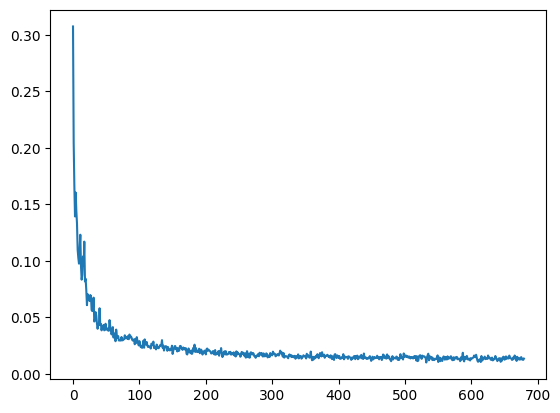

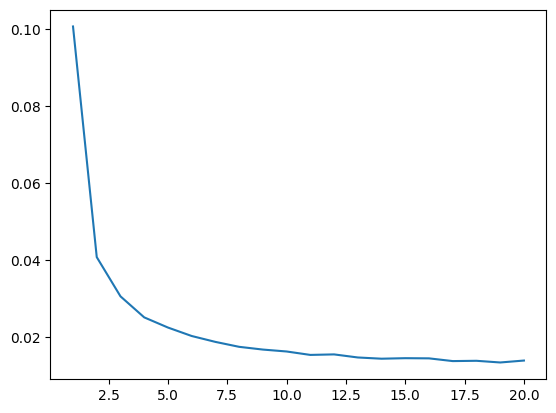

In [2]:
loss = pd.read_csv(path + 'train_loss.csv', sep=';')
plt.plot(loss['MAE'])
plt.show()

epoch_loss = loss.groupby('epoch')['MAE'].mean()
plt.plot(epoch_loss)
plt.show()

In [3]:
conf = pd.read_json(path + 'conf.json')
display(conf)

model = StockPriceModel(
    news_features=conf.loc[0, 'news_features'],
    rnn_n_layers=conf.loc[0, 'rnn_n_layers'],
    rnn_hidden_size=conf.loc[0, 'rnn_hidden_size'],
    seq_len=conf.loc[0, 'seq_len']
).float()

model.load_state_dict(torch.load(path + 'model.t7', map_location=torch.device('cpu')))
model.eval()

df = pd.read_csv('../data/dataset.csv', sep=';', index_col='time_stamp')
test_set = Dataset(
    df=df,
    testing=True,
    lag=conf.loc[0, 'lag'],
    seq_len=conf.loc[0, 'seq_len'],
    test_len=1,
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=True)

state = None
y_pred = test_set[0][1]
y_gt = test_set[0][1]
with torch.no_grad():
    for batch_idx, (time_stamp, x_price, x_news_input_ids, x_news_attention_mask, y) in enumerate(test_loader):
        print(batch_idx)
        #y_price, state = model(x_news_input_ids, x_news_attention_mask, x_price, state)
        y_price, state = model(x_price, x_news_input_ids, x_news_attention_mask, state)
        #print(y_price)
        #print(y_pred)
        #print(y)
        #y_pred = torch.cat((y_pred, y_price[0, :, :]), dim=0)
        y_pred = torch.cat((y_pred, y_price), dim=0)
        y_gt = torch.cat((y_gt, y[0, :, :]), dim=0)
    
        if batch_idx > 50:
            break

,batch_size,lr,epochs,news_features,rnn_n_layers,rnn_hidden_size,seq_len,lag
0,16,0.001,20,True,1,16,32,0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


torch.Size([84, 1])
torch.Size([84, 1])


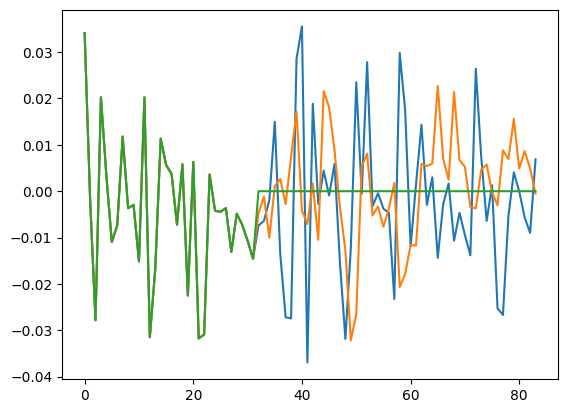

Test Loss: 0.8155518174171448
Zero predictor Loss: 0.6424758434295654


In [5]:
zero_pred = test_set[0][1]
zero_pred = torch.cat((zero_pred, torch.zeros(52, 1)), dim=0)
print(zero_pred.shape)
print(y_pred.shape)

plt.plot(y_gt)
plt.plot(y_pred)
plt.plot(zero_pred)
plt.show()

test_loss = torch.nn.L1Loss(reduction='sum')
print(f'Test Loss: {test_loss(y_gt, y_pred)}')
print(f'Zero predictor Loss: {test_loss(y_gt, zero_pred)}')